<a href="https://colab.research.google.com/github/kendraliu/Pneumonia-Prediction/blob/main/training_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
"""from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)"""

import pandas as pd
import numpy as np
import random
import cv2
import os
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.utils.set_random_seed(427)
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers import Dropout
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

/test: 234 normal, 390 pna

/val: 8 normal, 8 pna

/train: 1341 normal, 3875 pna

In [2]:
def normalArray(dataPath, dataImage, dataLabel):
    for filename in os.listdir(dataPath):
        img_path = os.path.join(dataPath, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))  # Resize to a common size
        image = image / 255.0  # Normalize pixel values to [0, 1]
        dataImage.append(image)
        dataLabel.append(0)
    dataImage = np.array(dataImage)
    dataLabel = np.array(dataLabel)
    return dataImage, dataLabel

In [3]:
def pnaArray(dataPath, dataImage, dataLabel):
    for filename in os.listdir(dataPath):
        img_path = os.path.join(dataPath, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))  # Resize to a common size
        image = image / 255.0  # Normalize pixel values to [0, 1]
        dataImage.append(image)
        dataLabel.append(1)
    dataImage = np.array(dataImage)
    dataLabel = np.array(dataLabel)
    return dataImage, dataLabel

In [4]:
def fitHistory(fit):
    history_df = pd.DataFrame(fit.history)
    history_df.index += 1  # Increase the index by 1 to match the number of epochs

    # Plot accuracy and loss history
    history_df.plot(y="accuracy")
    plt.title("Accuracy History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    history_df.plot(y="loss")
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [5]:
def cnnfitHistory(fit):
    history_df = pd.DataFrame(fit.history)
    history_df.index += 1  # Increase the index by 1 to match the number of epochs

    # Plot accuracy and loss history
    history_df.plot(y=["accuracy", "val_accuracy"])
    plt.title("Accuracy History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Test"])
    plt.show()

    history_df.plot(y=["loss", "val_loss"]) #include validation data
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Test"])
    plt.show()

In [6]:
def calculate_dnn_predict_classes(model, X_val, threshold=0.5):
    dnn_predict = model.predict(X_val)
    dnn_predict_classes = (dnn_predict > threshold).astype(int)
    return dnn_predict_classes

def dnnEval(model, X_val, y_val):
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print("Validation Loss:", val_loss)
    print("Validation Accuracy:", val_accuracy)

    dnn_predict_classes = calculate_dnn_predict_classes(model, X_val)

    # Calculate and print metrics
    accuracy = accuracy_score(y_val, dnn_predict_classes)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(y_val, dnn_predict_classes)
    tp = cm[1][1] / (cm[1][1] + cm[1][0])
    fn = cm[1][0] / (cm[1][1] + cm[1][0])
    fp = cm[0][1] / (cm[1][1] + cm[0][1])
    tn = cm[0][0] / (cm[0][0] + cm[0][1])

    print("Confusion Matrix:")
    print(cm)

    print("Classification Report:")
    print(classification_report(y_val, dnn_predict_classes))

    valSummary = pd.DataFrame({
    "accuracy": [accuracy],
    "loss": [round(val_loss, 2)],
    "true_positive": [round(tp, 2)],
    "false_negative": [round(fn, 2)],
    "false positive": [round(fp, 2)],
    "true_negative": [round(tn, 2)]
    })
    print(valSummary)

In [7]:
!pwd

/content


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
testNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/test/NORMAL"
testPNA = "drive/MyDrive/Pneumonia-Prediction/chest_xray/test/PNEUMONIA"
valNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/val/NORMAL"
valPNA = "drive/MyDrive/Pneumonia-Prediction/chest_xray/val/PNEUMONIA"
#trainNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/PNEUMONIA1"
trainNormal = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/group2"
trainPNA1 = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/group1"
#trainPNA2 = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/PNEUMONIA2"
#trainPNA3 = "drive/MyDrive/Pneumonia-Prediction/chest_xray/train/PNEUMONIA3"

In [10]:
os.listdir(valNormal) #check to see there's no random ".DS_Store" in directory
# if there is, run: find . -name ".DS_Store" -type f -delete
# or just run it anyway to be safe

['NORMAL2-IM-1440-0001.jpeg',
 'NORMAL2-IM-1438-0001.jpeg',
 'NORMAL2-IM-1431-0001.jpeg',
 'NORMAL2-IM-1427-0001.jpeg',
 'NORMAL2-IM-1437-0001.jpeg',
 'NORMAL2-IM-1442-0001.jpeg',
 'NORMAL2-IM-1436-0001.jpeg',
 'NORMAL2-IM-1430-0001.jpeg']

In [11]:
# images are X, labels are y
testNormalimage = []
testNormalLabel = []
testPNAimage = []
testPNALabel = []
valNormalimage = []
valNormalLabel = []
valPNAimage = []
valPNALabel = []
trainNormalimage = []
trainNormalLabel = []
trainPNAimage1 = []
trainPNALabel1= []


In [12]:
trainNormalimage, trainNormalLabel = normalArray(trainNormal, trainNormalimage, trainNormalLabel)
trainNormalimage.shape

(600, 224, 224, 3)

In [13]:
trainPNAimage1, trainPNALabel1 = pnaArray(trainPNA1, trainPNAimage1, trainPNALabel1)
trainPNAimage1.shape

(600, 224, 224, 3)

In [14]:
X_train = np.concatenate((trainNormalimage, trainPNAimage1), axis=0)
X_train.shape

(1200, 224, 224, 3)

In [15]:
y_train = np.concatenate((trainNormalLabel, trainPNALabel1), axis=0)
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
y_train.shape

(1200,)

In [17]:
valNormalimage, valNormalLabel = normalArray(valNormal, valNormalimage, valNormalLabel)
valNormalimage.shape

(8, 224, 224, 3)

In [18]:
valPNAimage, valPNALabel = pnaArray(valPNA, valPNAimage, valPNALabel)
valPNAimage.shape

(8, 224, 224, 3)

In [19]:
valPNALabel

array([1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
X_val = np.concatenate((valNormalimage, valPNAimage), axis=0)
#X_val

In [21]:
y_val = np.concatenate((valNormalLabel, valPNALabel), axis=0)
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
testNormalimage, testNormalLabel = normalArray(testNormal, testNormalimage, testNormalLabel)
testNormalimage.shape

(234, 224, 224, 3)

In [23]:
testPNAimage, testPNALabel = pnaArray(testPNA, testPNAimage, testPNALabel)
testPNAimage.shape

(390, 224, 224, 3)

In [24]:
X_test = np.concatenate((testNormalimage, testPNAimage), axis=0)
X_test.shape

(624, 224, 224, 3)

In [25]:
y_test = np.concatenate((testNormalLabel, testPNALabel), axis=0)
y_test.shape

(624,)

resplit

In [26]:
combinedValTestNormalImage = np.concatenate((valNormalimage, testNormalimage), axis=0)
combinedValTestPNAImage = np.concatenate((valPNAimage, testPNAimage), axis=0)
combinedValTestNormalLabel = np.concatenate((valNormalLabel, testNormalLabel), axis=0)
combinedValTestPNALabel = np.concatenate((valPNALabel, testPNALabel), axis=0)
combinedXValTest = np.concatenate((combinedValTestNormalImage, combinedValTestPNAImage), axis=0)
combinedyValTest = np.concatenate((combinedValTestNormalLabel, combinedValTestPNALabel), axis=0)
X_val40, X_test60, y_val40, y_test60 = train_test_split(combinedXValTest, combinedyValTest, test_size=0.6, random_state=42)
print(X_val40.shape)
print(X_test60.shape)
print(y_val40.shape)
print(y_test60.shape)

(256, 224, 224, 3)
(384, 224, 224, 3)
(256,)
(384,)


random sample

In [27]:
"""#test
random_index = random.sample(range(len(X_test60)), 80)
X_test_sampled = np.array([X_test60[i] for i in random_index])
y_test_sampled = np.array([y_test60[i] for i in random_index])
print(X_test_sampled.shape)
print(y_test_sampled.shape)"""

'#test\nrandom_index = random.sample(range(len(X_test60)), 80)\nX_test_sampled = np.array([X_test60[i] for i in random_index])\ny_test_sampled = np.array([y_test60[i] for i in random_index])\nprint(X_test_sampled.shape)\nprint(y_test_sampled.shape)'

In [28]:
#val
random_index = random.sample(range(len(X_val40)), 120)
X_val_sampled = np.array([X_val40[i] for i in random_index])
y_val_sampled = np.array([y_val40[i] for i in random_index])
print(X_val_sampled.shape)
print(y_val_sampled)

(120, 224, 224, 3)
[1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1
 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1
 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 0 1 0]


In [29]:
random_index = random.sample(range(len(X_train)), 600)
X_train_sampled = np.array([X_train[i] for i in random_index])
y_train_sampled = np.array([y_train[i] for i in random_index])
print(X_train_sampled.shape)
print(y_train_sampled.shape)

(600, 224, 224, 3)
(600,)


reshape (for dnn only)

In [ ]:
X_train_sampled_reshaped = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
print(X_train_sampled_reshaped.shape)

X_val_sampled_reshaped = X_val_sampled.reshape(X_val_sampled.shape[0], -1)
print(X_val_sampled_reshaped.shape)

"""X_test_sampled_reshaped = X_test_sampled.reshape(X_test_sampled.shape[0], -1)
print(X_test_sampled_reshaped.shape)"""

(600, 150528)
(120, 150528)


'X_test_sampled_reshaped = X_test_sampled.reshape(X_test_sampled.shape[0], -1)\nprint(X_test_sampled_reshaped.shape)'

# CNN

In [36]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(224, 224, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units=32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
cnn_model.add(layers.Dense(units=1, activation='sigmoid'))


train:  600
test:  120
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (N

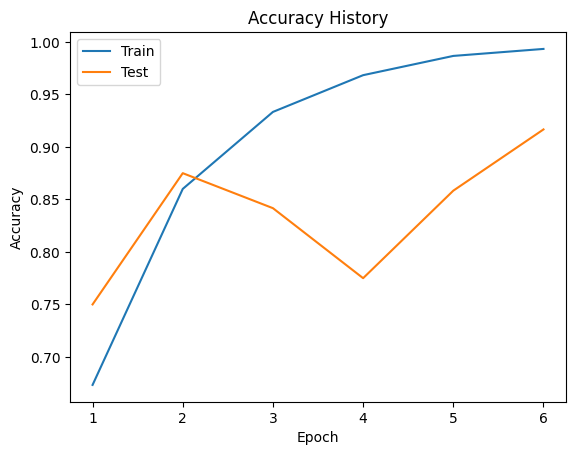

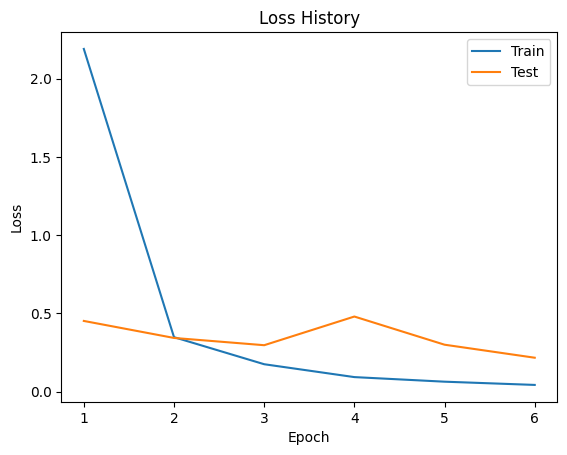

4/4 [==============================] - 3s 689ms/step - loss: 0.2171 - accuracy: 0.9167
Validation Loss: 0.21708005666732788
Validation Accuracy: 0.9166666865348816
4/4 [==============================] - 3s 701ms/step
Accuracy: 0.9166666666666666
Confusion Matrix:
[[36  6]
 [ 4 74]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        42
           1       0.93      0.95      0.94        78

    accuracy                           0.92       120
   macro avg       0.91      0.90      0.91       120
weighted avg       0.92      0.92      0.92       120

   accuracy  loss  true_positive  false_negative  false positive  \
0  0.916667  0.22           0.95            0.05            0.08   

   true_negative  
0           0.86  


In [37]:
print("train: ", X_train_sampled.shape[0])
print("test: ", X_val_sampled.shape[0])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()
fit16 = cnn_model.fit(X_train_sampled, y_train_sampled, epochs=6, batch_size=32, validation_data=(X_val_sampled, y_val_sampled))

cnnfitHistory(fit16)
dnnEval(cnn_model, X_val_sampled, y_val_sampled)

In [31]:
"""print("train: ", X_train_sampled.shape[0])
print("test: ", X_val_sampled.shape[0])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()
fit13 = cnn_model.fit(X_train_sampled, y_train_sampled, epochs=10, batch_size=32, validation_data=(X_val_sampled, y_val_sampled))"""

train:  600
test:  120
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (Non

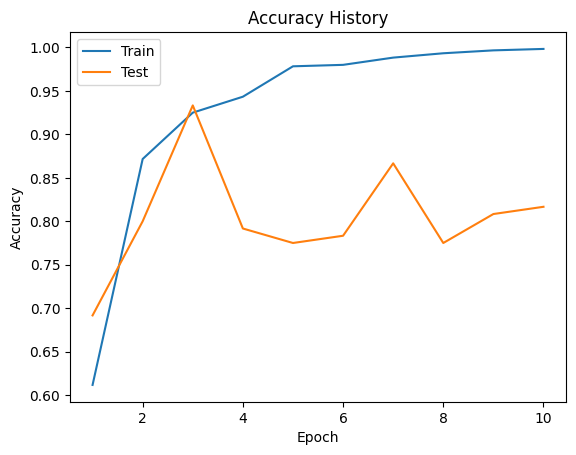

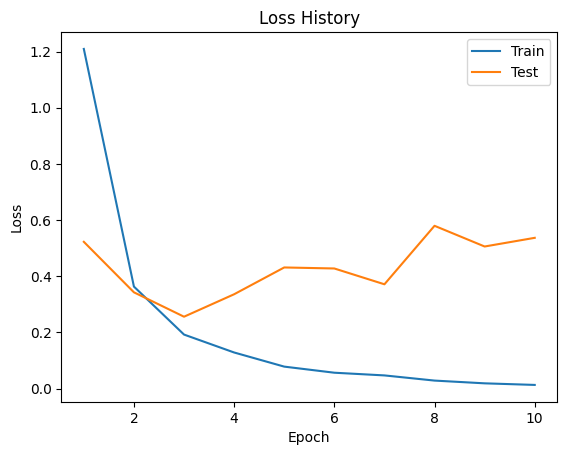

4/4 [==============================] - 3s 685ms/step - loss: 0.5367 - accuracy: 0.8167
Validation Loss: 0.5366774201393127
Validation Accuracy: 0.8166666626930237
4/4 [==============================] - 3s 678ms/step
Accuracy: 0.8166666666666667
Confusion Matrix:
[[22 20]
 [ 2 76]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.52      0.67        42
           1       0.79      0.97      0.87        78

    accuracy                           0.82       120
   macro avg       0.85      0.75      0.77       120
weighted avg       0.84      0.82      0.80       120

   accuracy  loss  true_positive  false_negative  false positive  \
0  0.816667  0.54           0.97            0.03            0.21   

   true_negative  
0           0.52  


In [32]:
cnnfitHistory(fit13)
dnnEval(cnn_model, X_val_sampled, y_val_sampled)

------------------------------

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()
fit13 = cnn_model.fit(X_train_sampled, y_train_sampled, epochs=10, batch_size=32, validation_data=(X_val_sampled, y_val_sampled))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

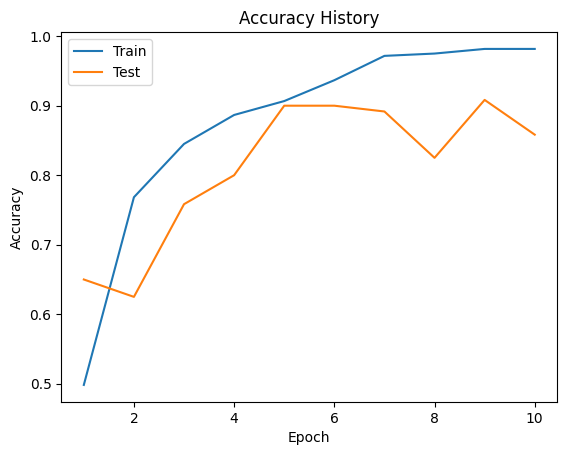

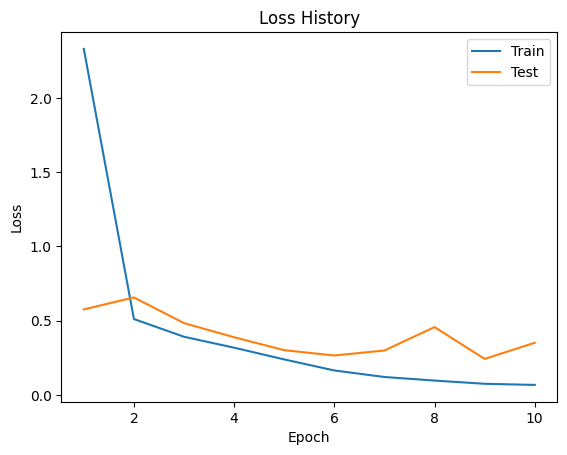

train:  600
test:  120


In [ ]:
cnnfitHistory(fit13)
print("train: ", X_train_sampled.shape[0])
print("test: ", X_val_sampled.shape[0])

In [ ]:
dnnEval(cnn_model, X_val_sampled, y_val_sampled)

4/4 [==============================] - 5s 1s/step - loss: 0.3510 - accuracy: 0.8583
Validation Loss: 0.3509725034236908
Validation Accuracy: 0.8583333492279053
4/4 [==============================] - 3s 669ms/step
Accuracy: 0.8583333333333333
Confusion Matrix:
[[27 17]
 [ 0 76]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        44
           1       0.82      1.00      0.90        76

    accuracy                           0.86       120
   macro avg       0.91      0.81      0.83       120
weighted avg       0.88      0.86      0.85       120

   accuracy  loss  true_positive  false_negative  false positive  \
0  0.858333  0.35            1.0             0.0            0.18   

   true_negative  
0           0.61  


In [61]:
cnn_model.save('drive/MyDrive/Pneumonia-Prediction/model.h5')

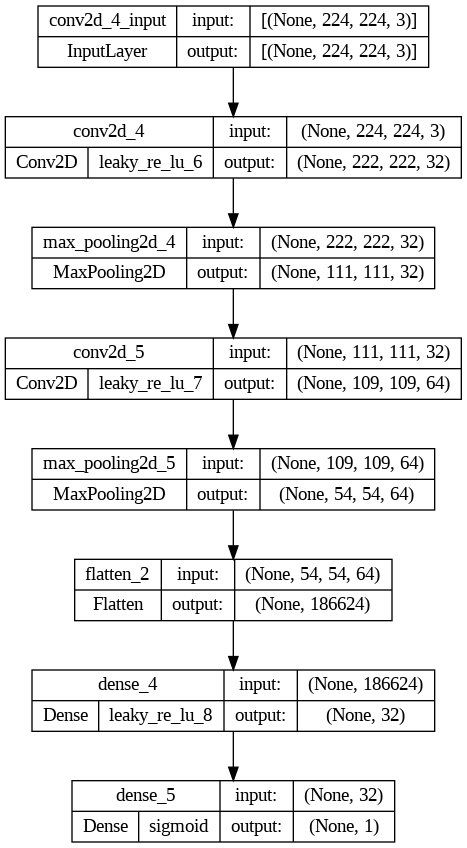

In [38]:
tf.keras.utils.plot_model(cnn_model, to_file="drive/MyDrive/Pneumonia-Prediction/cnn_model.png", show_shapes=True, show_layer_names=True,
                          show_layer_activations=True)

In [39]:
random_index_vis = random.sample(range(120), 8)
random_index_vis

[20, 78, 104, 62, 102, 46, 5, 21]

4/4 [==============================] - 3s 690ms/step
[0] [1]


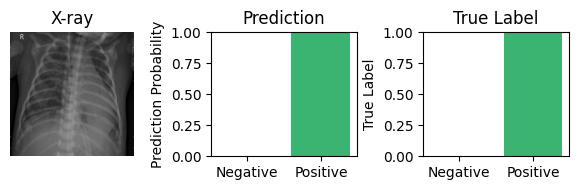

4/4 [==============================] - 3s 796ms/step
[0] [1]


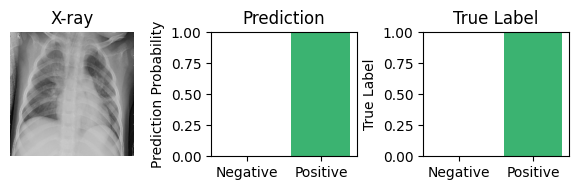

4/4 [==============================] - 3s 665ms/step
[0] [1]


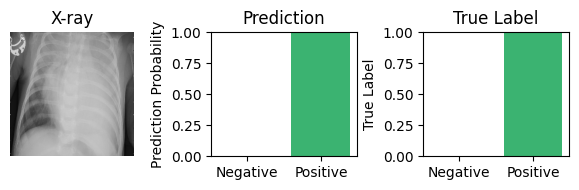

4/4 [==============================] - 3s 671ms/step
[1] [0]


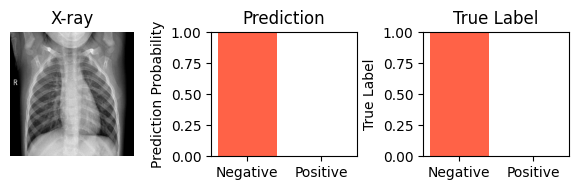

4/4 [==============================] - 3s 678ms/step
[0] [1]


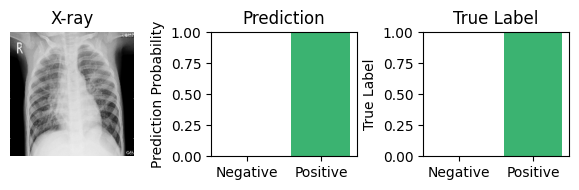

4/4 [==============================] - 3s 666ms/step
[1] [0]


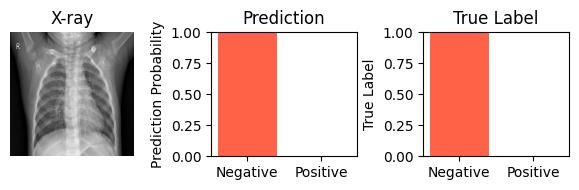

4/4 [==============================] - 4s 727ms/step
[0] [1]


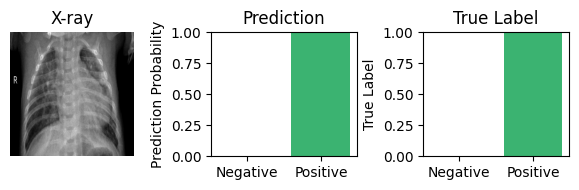

4/4 [==============================] - 3s 671ms/step
[1] [0]


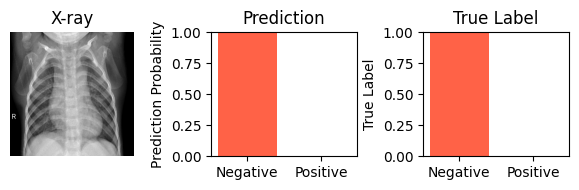

In [60]:
for i in range(len(random_index_vis)):
    image = X_val_sampled[i]
    prediction = calculate_dnn_predict_classes(cnn_model, X_val_sampled)
    print(1 - prediction[i], prediction[i])
    true_label = y_val_sampled[i]

    plt.figure(figsize=(6,2))

    # Display the image
    plt.subplot(1, 3, 1)
    plt.imshow(image.reshape(224, 224, 3), cmap=plt.cm.Greys)  # Reshape the image back to (224, 224, 3)
    plt.axis('off')
    plt.title('X-ray')

    # Display the prediction
    plt.subplot(1, 3, 2)
    plt.bar(['Negative', 'Positive'], [1 - prediction[i][0], prediction[i][0]], color=['#FF6247', '#3BB371'])
    plt.ylabel('Prediction Probability')
    plt.ylim([0, 1])
    plt.title('Prediction')

    # Display the true label
    plt.subplot(1, 3, 3)
    plt.bar(['Negative', 'Positive'], [1 - true_label, true_label], color=['#FF6247', '#3BB371'])
    plt.ylabel('True Label')
    plt.ylim([0, 1])
    plt.title('True Label')

    plt.tight_layout()
    #plt.savefig(f"drive/MyDrive/Pneumonia-Prediction/validation_{i}.png")
    plt.show()

In [ ]:
"""datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,   # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    zoom_range=0.2,          # up to 20%
    horizontal_flip=True,
    vertical_flip=False      # Don't flip images vertically
)"""

In [ ]:
"""cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(224, 224, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units=32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
cnn_model.add(layers.Dense(units=1, activation='sigmoid'))"""

In [ ]:
"""print("train: ", X_train_sampled.shape[0])
print("val: ", X_val_sampled.shape[0])
#print("testfit X_test_sampled_reshaped.shape[0])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()
datagen.fit(X_train_sampled)
fit14 = cnn_model.fit(datagen.flow(X_train_sampled, y_train_sampled, batch_size=32), epochs=10, validation_data=(X_val_sampled, y_val_sampled))"""

train:  600
val:  120
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (No

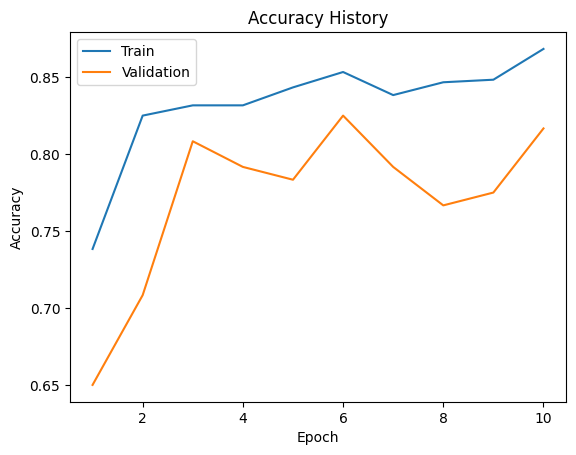

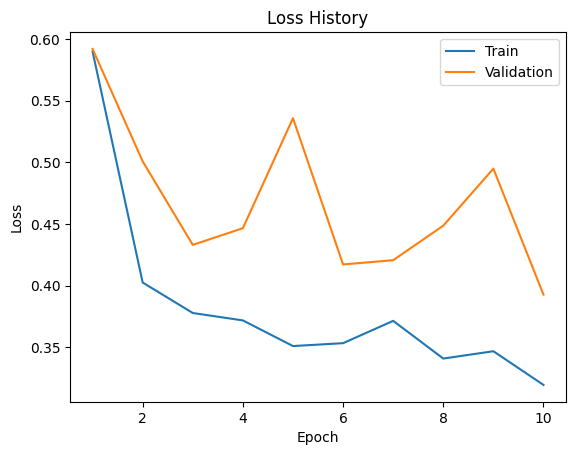

4/4 [==============================] - 3s 675ms/step - loss: 0.3928 - accuracy: 0.8167
Validation Loss: 0.39280620217323303
Validation Accuracy: 0.8166666626930237
4/4 [==============================] - 4s 885ms/step
Accuracy: 0.8166666666666667
Confusion Matrix:
[[36  8]
 [14 62]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        44
           1       0.89      0.82      0.85        76

    accuracy                           0.82       120
   macro avg       0.80      0.82      0.81       120
weighted avg       0.82      0.82      0.82       120

   accuracy  loss  true_positive  false_negative  false positive  \
0  0.816667  0.39           0.82            0.18            0.11   

   true_negative  
0           0.82  


In [ ]:
"""cnnfitHistory(fit14)
dnnEval(cnn_model, X_val_sampled, y_val_sampled)"""

# DNN

In [ ]:
dnnModel = tf.keras.models.Sequential()
dnnModel.add(tf.keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_dim=150528))
dnnModel.add(tf.keras.layers.Dense(units=32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=16, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
#dnnModel.add(tf.keras.layers.Dense(units=5, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

train:  600
val:  120
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                9633856   
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9,636,481
Trainable params: 9,636,481
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
19/19 [==============================] - 5s 176ms/step - loss: 21.1203 - accuracy: 0.5233
Epoch 2/60
19/19 [==============================

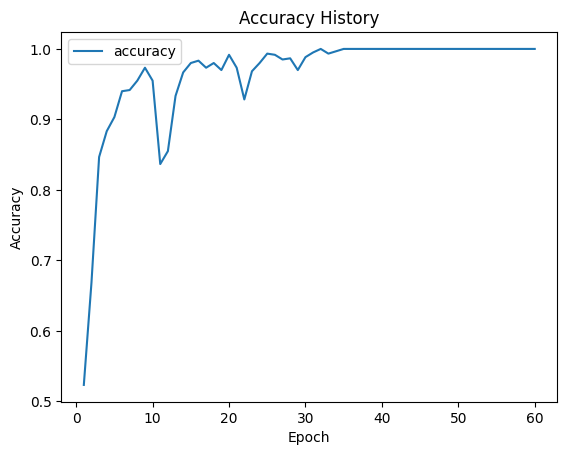

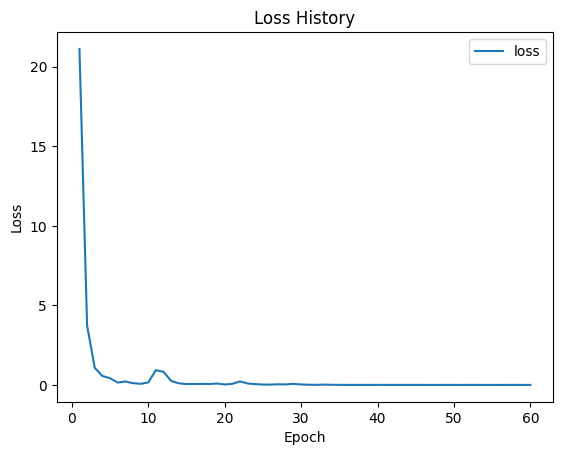

-------------------------------------------------
-------------------------------------------------
4/4 [==============================] - 0s 25ms/step - loss: 0.9492 - accuracy: 0.8250
Validation Loss: 0.9491519927978516
Validation Accuracy: 0.824999988079071
4/4 [==============================] - 0s 24ms/step
Accuracy: 0.825
Confusion Matrix:
[[25 18]
 [ 3 74]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.58      0.70        43
           1       0.80      0.96      0.88        77

    accuracy                           0.82       120
   macro avg       0.85      0.77      0.79       120
weighted avg       0.84      0.82      0.81       120

   accuracy  loss  true_positive  false_negative  false positive  \
0     0.825  0.95           0.96            0.04             0.2   

   true_negative  
0           0.58  


In [ ]:
print("train: ", X_train_sampled_reshaped.shape[0])
print("val: ", X_val_sampled_reshaped.shape[0])
#print("testfit12 X_test_sampled_reshaped.shape[0])
print(dnnModel.summary())

dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit12 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=60)

fitHistory(fit12)

print(f"-------------------------------------------------\n-------------------------------------------------")

dnnEval(dnnModel, X_val_sampled_reshaped, y_val_sampled)


In [ ]:
"""dnnModel = tf.keras.models.Sequential()
dnnModel.add(tf.keras.layers.Dense(units=50, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_dim=150528))
dnnModel.add(tf.keras.layers.Dense(units=30, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=10, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
#dnnModel.add(tf.keras.layers.Dense(units=5, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))"""

train:  600
val:  120
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                7526450   
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 7,528,301
Trainable params: 7,528,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
19/19 [==============================] - 4s 140ms/step - loss: 2.6856 - accuracy: 0.5550
Epoch 2/60
19/19 [==============================]

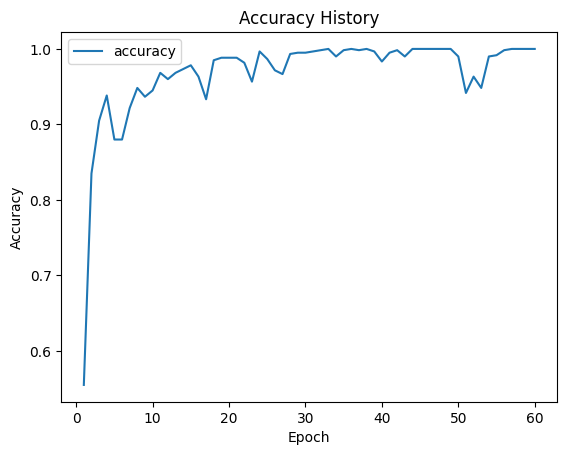

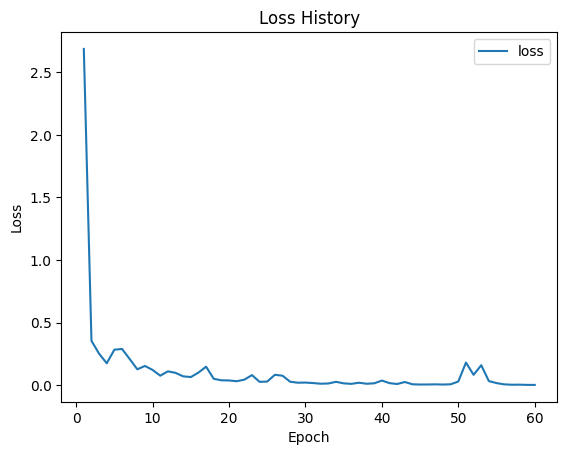

-------------------------------------------------/n-------------------------------------------------
4/4 [==============================] - 0s 25ms/step - loss: 1.1458 - accuracy: 0.8083
Validation Loss: 1.1457573175430298
Validation Accuracy: 0.8083333373069763
4/4 [==============================] - 0s 24ms/step
Accuracy: 0.8083333333333333
Confusion Matrix:
[[22 21]
 [ 2 75]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.51      0.66        43
           1       0.78      0.97      0.87        77

    accuracy                           0.81       120
   macro avg       0.85      0.74      0.76       120
weighted avg       0.83      0.81      0.79       120

   accuracy  loss  true_positive  false_negative  false positive  \
0  0.808333  1.15           0.97            0.03            0.22   

   true_negative  
0           0.51  


In [ ]:
print("train: ", X_train_sampled_reshaped.shape[0])
print("val: ", X_val_sampled_reshaped.shape[0])
#print("testfit11 X_test_sampled_reshaped.shape[0])
print(dnnModel.summary())

dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit11 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=60)

fitHistory(fit11)

print(f"-------------------------------------------------\n-------------------------------------------------")

dnnEval(dnnModel, X_val_sampled_reshaped, y_val_sampled)


In [ ]:
"""dnnModel = tf.keras.models.Sequential()
dnnModel.add(tf.keras.layers.Dense(units=40, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_dim=150528))
dnnModel.add(tf.keras.layers.Dense(units=25, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=13, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=5, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))"""

train:  600
val:  120
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                6021160   
                                                                 
 dense_1 (Dense)             (None, 25)                1025      
                                                                 
 dense_2 (Dense)             (None, 13)                338       
                                                                 
 dense_3 (Dense)             (None, 5)                 70        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 6,022,599
Trainable params: 6,022,599
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
19/19 [=

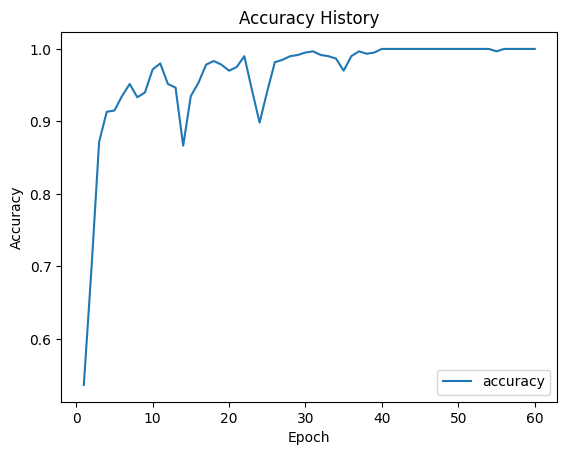

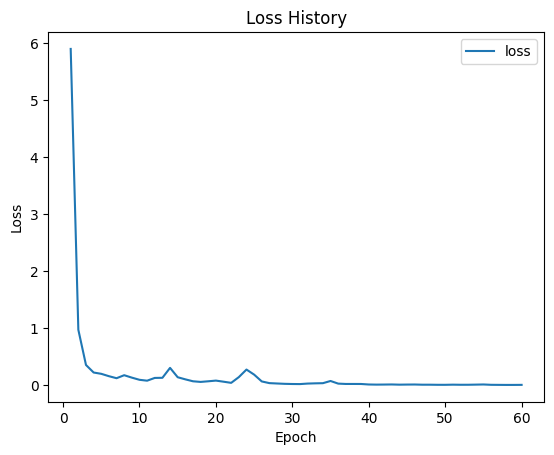

In [ ]:
print("train: ", X_train_sampled_reshaped.shape[0])
print("val: ", X_val_sampled_reshaped.shape[0])
#print("testfit10 X_test_sampled_reshaped.shape[0])
print(dnnModel.summary())

dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit10 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=60)

fitHistory(fit10)

In [ ]:
dnnEval(dnnModel, X_val_sampled_reshaped, y_val_sampled)

4/4 [==============================] - 0s 30ms/step - loss: 0.8737 - accuracy: 0.8000
Validation Loss: 0.8737459778785706
Validation Accuracy: 0.800000011920929
4/4 [==============================] - 0s 27ms/step
Accuracy: 0.8
Confusion Matrix:
[[23 20]
 [ 4 73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.53      0.66        43
           1       0.78      0.95      0.86        77

    accuracy                           0.80       120
   macro avg       0.82      0.74      0.76       120
weighted avg       0.81      0.80      0.79       120

   accuracy  loss  true_positive  false_negative  false positive  \
0       0.8  0.87           0.95            0.05            0.22   

   true_negative  
0           0.53  


In [ ]:
"""dnnModel.add(tf.keras.layers.Dense(units=40, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_dim=150528))
dnnModel.add(tf.keras.layers.Dense(units=25, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=13, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))"""

train:  600
val:  120
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 40)                6021160   
                                                                 
 dense_13 (Dense)            (None, 25)                1025      
                                                                 
 dense_14 (Dense)            (None, 13)                338       
                                                                 
 dense_15 (Dense)            (None, 1)                 14        
                                                                 
Total params: 6,022,537
Trainable params: 6,022,537
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
19/19 [==============================] - 4s 93ms/step - loss: 2.0034 - accuracy: 0.5683
Epoch 2/60
19/19 [==============================] 

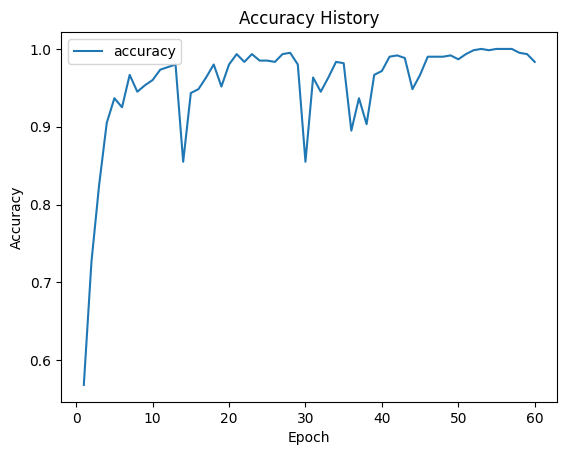

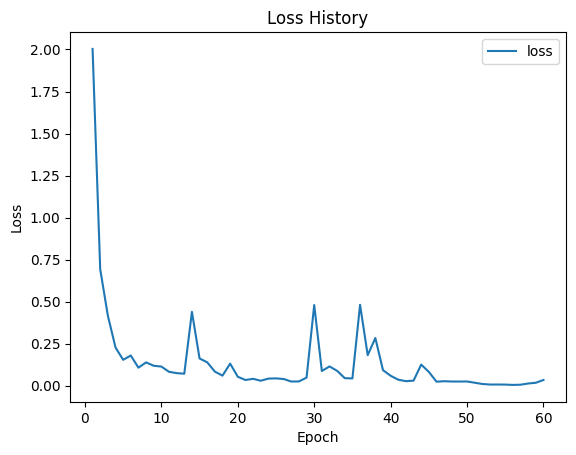

In [ ]:
print("train: ", X_train_sampled_reshaped.shape[0])
print("val: ", X_val_sampled_reshaped.shape[0])
#print("test: ", X_test_sampled_reshaped.shape[0])
print(dnnModel.summary())

dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit9 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=60)

fitHistory(fit9)

In [ ]:
dnnEval(dnnModel, X_val_sampled_reshaped, y_val_sampled)

4/4 [==============================] - 0s 16ms/step - loss: 0.6763 - accuracy: 0.8000
Validation Loss: 0.6762930750846863
Validation Accuracy: 0.800000011920929
4/4 [==============================] - 0s 15ms/step
Accuracy: 0.8
Confusion Matrix:
[[22 16]
 [ 8 74]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.82      0.90      0.86        82

    accuracy                           0.80       120
   macro avg       0.78      0.74      0.75       120
weighted avg       0.79      0.80      0.79       120

   accuracy  true_positive  false_negative  false positive  true_negative
0       0.8       0.902439        0.097561        0.177778       0.578947


In [ ]:
"""dnnModel.add(tf.keras.layers.Dense(units=20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_dim=150528))
dnnModel.add(tf.keras.layers.Dense(units=15, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
dnnModel.add(tf.keras.layers.Dense(units=8, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
#dnnModel.add(tf.keras.layers.Dense(units=3, activation="ReLu"))
dnnModel.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))"""

train:  600
val:  120
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                3010580   
                                                                 
 dense_5 (Dense)             (None, 15)                315       
                                                                 
 dense_6 (Dense)             (None, 8)                 128       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,011,032
Trainable params: 3,011,032
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
19/19 [==============================] - 2s 57ms/step - loss: 5.4766 - accuracy: 0.5200
Epoch 2/60
19/19 [==============================] 

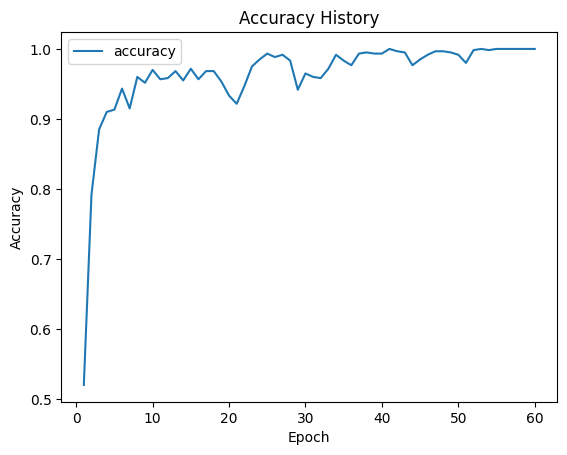

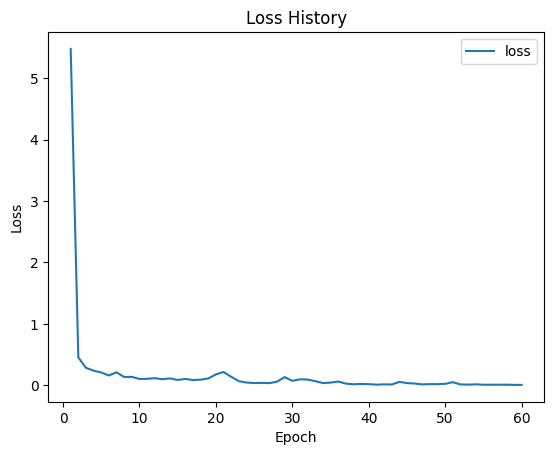

In [ ]:
print("train: ", X_train_sampled_reshaped.shape[0])
print("val: ", X_val_sampled_reshaped.shape[0])
#print("test: ", X_test_sampled_reshaped.shape[0])
print(dnnModel.summary())

dnnModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit8 = dnnModel.fit(X_train_sampled_reshaped, y_train_sampled, epochs=60)

fitHistory(fit8)

In [ ]:
dnnEval(dnnModel, X_val_sampled_reshaped, y_val_sampled)

4/4 [==============================] - 0s 16ms/step - loss: 0.8784 - accuracy: 0.7667
Validation Loss: 0.8784344792366028
Validation Accuracy: 0.7666666507720947
4/4 [==============================] - 0s 14ms/step
Accuracy: 0.7666666666666667
Confusion Matrix:
[[16 22]
 [ 6 76]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.42      0.53        38
           1       0.78      0.93      0.84        82

    accuracy                           0.77       120
   macro avg       0.75      0.67      0.69       120
weighted avg       0.76      0.77      0.75       120

   accuracy  true_positive  false_negative  false positive  true_negative
0  0.766667       0.926829        0.073171         0.22449       0.421053


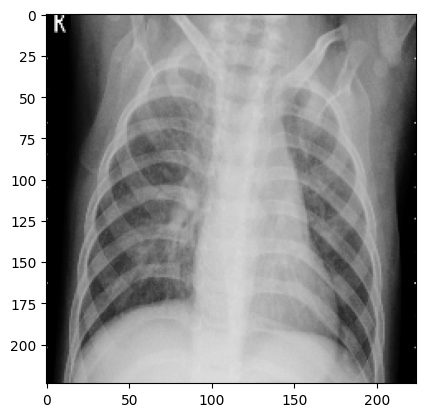

In [ ]:
plt.imshow(X_val_sampled[0,:,:], cmap=plt.cm.Greys)

In [ ]:
X_val_sampled.shape

(120, 224, 224, 3)

1/1 [==============================] - 0s 57ms/step


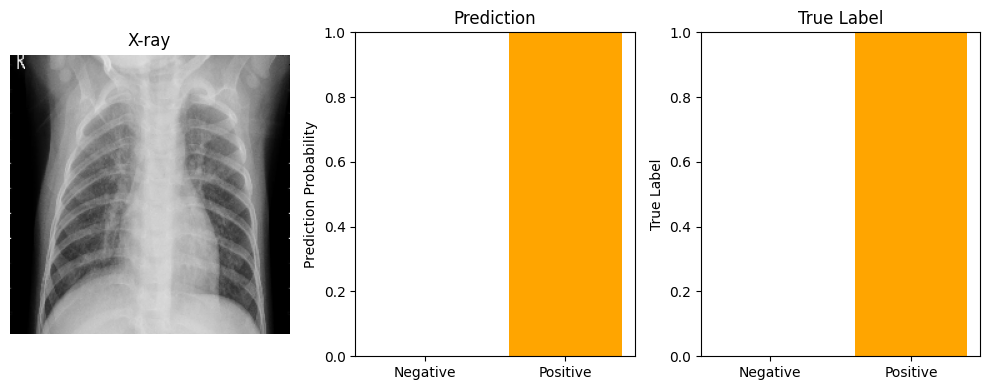

1/1 [==============================] - 0s 40ms/step


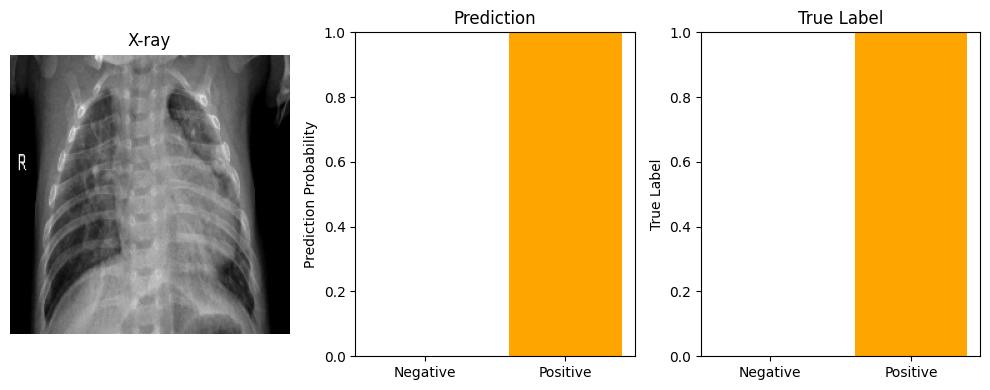

1/1 [==============================] - 0s 40ms/step


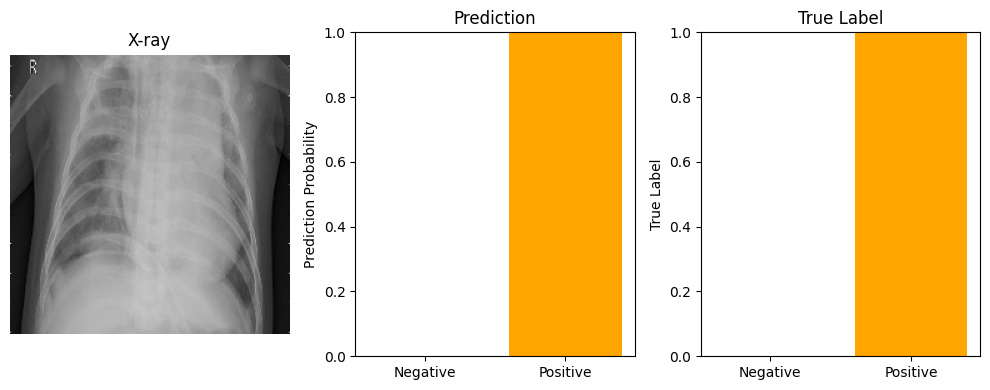

1/1 [==============================] - 0s 41ms/step


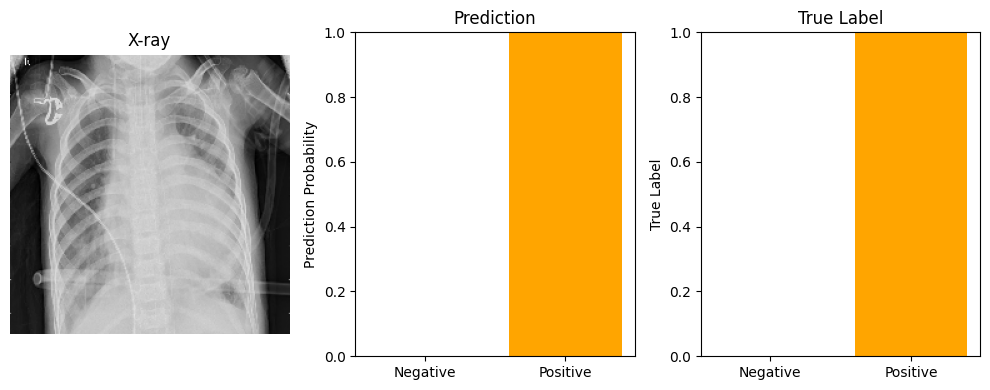

1/1 [==============================] - 0s 40ms/step


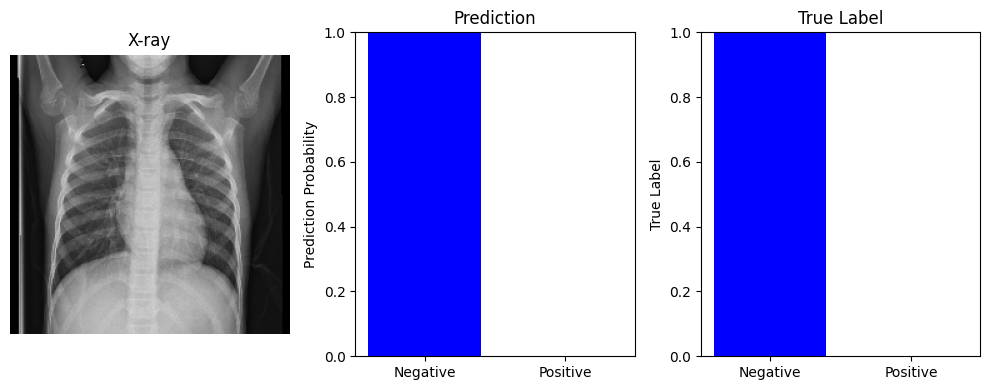

In [ ]:
for i in range(15,20):
    image = X_val_sampled_reshaped[i]
    prediction = calculate_dnn_predict_classes(dnnModel, X_val_sampled_reshaped)
    #print(1 - prediction[i], prediction[i])
    true_label = y_val_sampled[i]

    plt.figure(figsize=(5,2))

    # Display the image
    plt.subplot(1, 3, 1)
    plt.imshow(image.reshape(224, 224, 3), cmap=plt.cm.Greys)  # Reshape the image back to (224, 224, 3)
    plt.axis('off')
    plt.title('X-ray')

    # Display the prediction
    plt.subplot(1, 3, 2)
    plt.bar(['Negative', 'Positive'], [1 - prediction[i][0], prediction[i][0]], color=['blue', 'orange'])
    plt.ylabel('Prediction Probability')
    plt.ylim([0, 1])
    plt.title('Prediction')

    # Display the true label
    plt.subplot(1, 3, 3)
    plt.bar(['Negative', 'Positive'], [1 - true_label, true_label], color=['blue', 'orange'])
    plt.ylabel('True Label')
    plt.ylim([0, 1])
    plt.title('True Label')

    plt.tight_layout()
    plt.savefig(f"drive/MyDrive/Pneumonia-Prediction/validation_{i}.png")
    plt.show()